### Imports

In [1]:
import numpy as np
import time
from tqdm import tqdm
import json, pickle
import warnings
import os, sys
import copy
import itertools
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
# import torch
# import torchvision
# from torch.nn.utils.rnn import pad_sequence
# import torchvision.transforms as transforms
# from torch.utils.data import Dataset

warnings.filterwarnings("ignore")   # ignore stupid dataloader warnings

In [10]:
# # hyperparameters
ROOT_DIR = './data'
# # check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

### Load data

In [5]:
# dataset = VisualGenome(root_dir=ROOT_DIR, transform=None)
# print(f'number of samples in the dataset: {len(dataset)}')
# # get small subset of the dataset for testing
# indices = np.random.randint(0, len(dataset), size=1000)
# subset_dataset = torch.utils.data.Subset(dataset, indices)

# def collate_fn(batch):
#     return zip(*batch)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=None)
# subset_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=None)

number of samples in the dataset: 108077


### Preprocessing (for VG)

In [16]:
# read original objects file
obj_path = f'{ROOT_DIR}/vg/vg_objects.json'
with open(obj_path) as f:
    all_objs = json.load(f)
print(f'size of all_objs in bytes: {sys.getsizeof(all_objs)}')

size of all_objs in bytes: 901144


#### Replace aliases

In [17]:
# read aliases from file where each line is a list of aliases
with open(f'{ROOT_DIR}/vg/vg_object_aliases.txt') as f:
    aliases = f.readlines()
aliases = [a.strip().split(',') for a in aliases]
print(f'number of aliases: {len(aliases)}')
print(f'first 5 aliases: {aliases[:5]}')

number of aliases: 3435
first 5 aliases: [['called a forest', 'is called a forest'], ['saver', 'savers'], ['bookend', 'bookends'], ['yellow', 'is yellow', 'yellows'], ['gladiola', 'gladiolas']]


In [22]:
# replace aliases with the first alias
all_objs_new = copy.deepcopy(all_objs)
for i, obj in tqdm(enumerate(all_objs_new)):
    for j, object in enumerate(obj['objects']):
        for a in aliases:
            if object['names'][0] in a[1:]:
                # print(f'replacing {object["names"][0]} with {a[0]} in {obj["image_id"]}')
                all_objs_new[i]['objects'][j]['names'][0] = a[0]
                break

108077it [18:02, 99.81it/s] 


In [23]:
# count number of objects with aliases
alias_counts = {'old': defaultdict(lambda: 0), 'new': defaultdict(lambda: 0)}
for i, obj in tqdm(enumerate(all_objs[:1000])):
    for j, object in enumerate(obj['objects']):
        for a in aliases:
            if object['names'][0] in a[1:]:
                # print(f'found alias {a[0]} for {object["names"][0]} in {obj["image_id"]}')
                alias_counts['old'][a[0]] += 1
                break
for i, obj in tqdm(enumerate(all_objs_new[:1000])):
    for j, object in enumerate(obj['objects']):
        for a in aliases:
            if object['names'][0] in a[1:]:
                # print(f'found alias {a[0]} for {object["names"][0]} i')
                alias_counts['new'][a[0]] += 1
                break
print(f'number of objects with aliases: {sum(alias_counts["old"].values())}')
print(f'top 5 most common aliases: {sorted(alias_counts["old"].items(), key=lambda x: x[1], reverse=True)[:5]}')
print(f'number of objects with aliases after replacement: {sum(alias_counts["new"].values())}')

1000it [00:07, 127.95it/s]
1000it [00:08, 123.30it/s]

number of objects with aliases: 1744
top 5 most common aliases: [('leaf', 131), ('window', 103), ('tree', 84), ('pant', 73), ('flower', 50)]
number of objects with aliases after replacement: 0


#### Remove rare entities

In [24]:
# remove objs with no objects in them
all_objs_new = [obj for obj in all_objs_new if len(obj['objects']) > 0]
obj_freqs = defaultdict(lambda: 0)
for idx, obj in tqdm(enumerate(all_objs_new)):
    for name in set([object['names'][0] for object in obj['objects']]):
        obj_freqs[name] += 1
print(f'\ntotal number of objects: {len(all_objs)}')
print('\ntotal number of names: {}'.format(len(obj_freqs)))
print(f'# objects with freq > 100: {len([k for k, v in obj_freqs.items() if v > 100])}')
# remove objects with freq < 100
for i, obj in tqdm(enumerate(all_objs_new)):
    all_objs_new[i]['objects'] = [object for object in obj['objects'] if obj_freqs[object['names'][0]] >= 100]
# count total number of objects
print(f'total number of objects: {len(all_objs_new)}')
obj_names = set([name for obj in all_objs_new for name in [object['names'][0] for object in obj['objects']]])
print(f'first 5 object names: {list(obj_names)[:5]}')
print(f'# object categories: {len(obj_names)}')

In [34]:
# save new objects file
with open(f'{ROOT_DIR}/vg/vg_objects_clean.json', 'w') as f:
    json.dump(all_objs_new, f)

In [15]:
# load new objects file
with open(f'{ROOT_DIR}/vg/vg_objects_clean.json', 'r') as f:
    all_objs = json.load(f)
obj_names = set([name for obj in all_objs for name in [object['names'][0] for object in obj['objects']]])
print(f'# object categories: {len(obj_names)}')

# object categories: 1443


### Exp 2: plot recall values for different anno rates 

[]

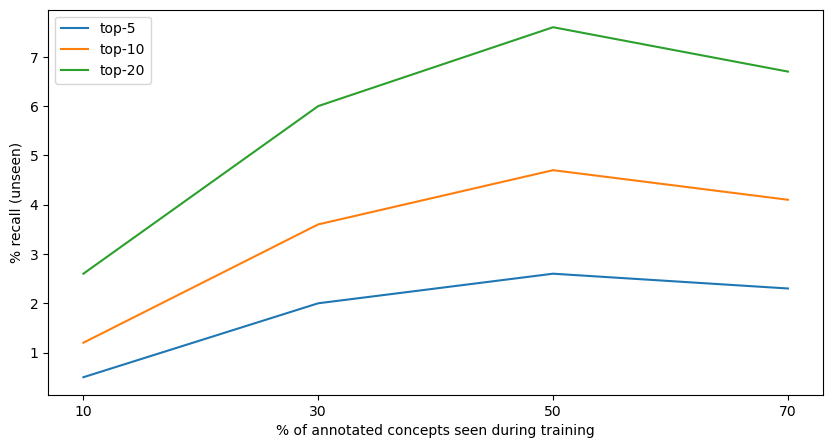

In [13]:
anno_rates = [0.1, 0.3, 0.5, 0.7]
recalls = ['top-5', 'top-10', 'top-20']
recalls_df = pd.DataFrame(columns=['% unseen concepts discovered'] + recalls, index=anno_rates)
recalls_df.loc[0.1, :] = [0.236, 0.005, 0.012, 0.026]
recalls_df.loc[0.3, :] = [0.314, 0.02, 0.036, 0.06]
recalls_df.loc[0.5, :] = [0.328, 0.026, 0.047, 0.076]
recalls_df.loc[0.7, :] = [0.3, 0.023, 0.041, 0.067]
# plot
ax = recalls_df.iloc[:, 1:].plot(figsize=(10, 5), title='', xlabel='% of annotated concepts seen during training', ylabel='% recall (unseen)')
ax.set_xticks(anno_rates)
ax.set_xticklabels([f'{int(100 * x)}' for x in ax.get_xticks()])
ax.set_yticklabels([f'{int(100 * x)}' for x in ax.get_yticks()])
ax.plot()

In [14]:
# save dataframe to latex
print(recalls_df.to_latex())

\begin{tabular}{lllll}
\toprule
{} & \% unseen concepts discovered &  top-5 & top-10 & top-20 \\
\midrule
0.1 &                        0.236 &  0.005 &  0.012 &  0.026 \\
0.3 &                        0.314 &   0.02 &  0.036 &   0.06 \\
0.5 &                        0.328 &  0.026 &  0.047 &  0.076 \\
0.7 &                          0.3 &  0.023 &  0.041 &  0.067 \\
\bottomrule
\end{tabular}

